In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.base import BaseEstimator, TransformerMixin

import warnings

warnings.filterwarnings('ignore')


def load_csv(file_path, index_col='Id', parse_dates=True):
    df = pd.read_csv(file_path,  parse_dates=parse_dates, index_col='Id')
    return df

def delete_noise(X, indices):
    X.drop(indices, inplace = True, errors='ignore')
    X.reset_index(drop=True)    
    return

def get_irrilevant_cols(X, perc_treshold=90, fraction_total=2):
    row_count = X.shape[0]
    cols_to_delete = []
    for col in X.columns:
        values_counting = X[col].value_counts().reset_index().rename(columns={'index': 'val', col: 'counts'})
        top_values = values_counting.sort_values(by='count', ascending=False).head(2)
        perc_top= (top_values.iloc[0,1]/row_count)*100
        if(perc_top>perc_treshold):
            cols_to_delete.append(col)

        count = 0
        if (X[col].dtype == 'int64') or (X[col].dtype == 'float64'):
            count = X[X[col] > 0].shape[0]
        else:
            count = X[X[col].notna()].shape[0]

        if(count<row_count/fraction_total):
            cols_to_delete.append(col)

    return cols_to_delete

def find_outliers(X, col, quantile_param):
    if X[col].dtype in ['int64', 'float64']:  # Se la colonna è numerica
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        if lower_bound<0:
            lower_bound=0
        print(f'lower and upper bound for {col}: {lower_bound} : {upper_bound}')
        outlier_indices = X[(X[col] < lower_bound) | (X[col] > upper_bound)].index
    
    elif X[col].dtype == 'object':  # Se la colonna è categoriale
        # Ottieni le frequenze delle categorie
        freq = X[col].value_counts(normalize=True)
        # Identifica le categorie che compaiono meno del 5% delle volte
        rare_categories = freq[freq < 0.05].index
        print(f'rare_categories for {col}: {rare_categories}')
        
        outlier_indices = X[X[col].isin(rare_categories)].index
    
    else:
        raise ValueError("Tipo di dati non supportato per la colonna: " + str(X[col].dtype))
    
    return outlier_indices.to_numpy()

def delete_outliers(X, outliers):
    for key in outliers:
        X.drop(key, inplace = True, errors='ignore')

def delete_outliers(X, outliers):
    for key in outliers:
        X.drop(key, inplace = True, errors='ignore')

    return X

def label_encode(X):
    le = LabelEncoder()
    return np.array([le.fit_transform(col) for col in X.T]).T  

def to_lowercase(df):
    return df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
    

def encode_with_custom_order(df, column_name, order_values):
    unique_values = [value.lower() if isinstance(value, str) else value for value in df[column_name].unique()]
    valid_values = [value.lower() for value in order_values if value in unique_values]
    return valid_values

def remove_original_columns(X):
    return X[:, -3:]  # Supponendo che l'output di svd abbia 3 colonne


def repair_nan(X, colname, mode='value', value=0):
        if isinstance(colname, str):
            colname = [colname]

        for col in colname:
            if col not in X.columns:
                print(f"{col} not found DataFrame.")
                continue

            if mode == 'value':
                X[col].fillna(value, inplace=True)
            elif mode == 'delrow':
                X.dropna(subset=[col], inplace=True)
            elif mode == 'mostcommon':
                most_common = X[col].mode()[0] 
                X[col].fillna(most_common, inplace=True)
            elif mode == 'mean':
                mean_value = X[col].mean()
                X[col].fillna(mean_value, inplace=True)
            elif mode == 'min':
                min_value = X[col].min()
                X[col].fillna(min_value, inplace=True)
            elif mode == 'max':
                max_value = X[col].max()
                X[col].fillna(max_value, inplace=True)
            elif mode == 'random_number':
                mean_value = X[col].mean()
                std_dev = X[col].std()  
                def is_nan(x):
                    return pd.isna(x)
                
                def random_error(x):
                    if is_nan(x):
                        return random.gauss(mean_value, 2 * std_dev) 
                    return x
            
                X[col] = X[col].apply(random_error)            
            else:
                print(f'{mode} not found')

        return


def correct_nan(X):
    # Correction for great missing values
    print('correction nan')
    repair_nan(X, colname='FireplaceQu', mode='value', value='NA') # Set to NA --> il campo viene eliminato comunque
    repair_nan(X, colname='MasVnrType', mode='value', value='NA') # Set to NA --> il campo viene eliminato comunque
    repair_nan(X, colname='LotFrontage', mode='value', value=0) # Set to 0 --> il campo viene eliminato comunque
    
    # Small corrections
    repair_nan(X, colname='MasVnrArea', mode='value', value=0) # Set to 0
    repair_nan(X, colname='BsmtQual', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='BsmtCond', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='BsmtExposure', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='BsmtFinType1', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='BsmtFinType2', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='Electrical', mode='mostcommon')  # most common
    repair_nan(X, colname='FireplaceQu', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='GarageType', mode='value', value='NA') # Set to NA
#    repair_nan(X, colname='GarageYrBlt', mode='value', value=0)  # Set to 0???
    repair_nan(X, colname='GarageFinish', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='GarageQual', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='GarageCond', mode='value', value='NA') # Set to NA
    
    return X


# Estendo la classe onehot per inserire l'unknown
# Posso anche ridurre il numero di colonne tramite percentuale limite per categorie rare
class OneHotWithOther(BaseEstimator, TransformerMixin):
    def __init__(self, column_names, perc_thresholdOther=0.05):
        if not isinstance(column_names, list):
            raise ValueError("column_names deve essere una lista di nomi di colonne.")
        
        self.column_names = column_names
        self.perc_thresholdOther = perc_thresholdOther
        self.category_dict = {}
        self.other_category = 'other'

    def fit(self, X, y=None):
        countRows = X.shape[0]
        tresholdForCol = countRows * self.perc_thresholdOther
        #print(f'threshold:{tresholdForCol}')
        for column in self.column_names:
            if column not in X.columns:
                raise ValueError(f"La colonna {column} non esiste nel DataFrame.")
            
            possibleCategories = pd.Series(X[column]).unique()
            categToAdd = []
            for cat in possibleCategories:
                conteggiCat = X[X[column] == cat].shape[0]
                if  conteggiCat > tresholdForCol:
                    categToAdd.append(cat)
                    
            self.category_dict[column]=categToAdd
#            print(f'self.category_dict[column]: {self.category_dict[column]}')  
        
        return self

    def transform(self, X):
        X_transformed = X.copy()
        
        for column in self.column_names:
            if column not in self.category_dict:
                raise RuntimeError(f"Il fit deve essere eseguito per {column} prima di chiamare transform.")

            # Crea una colonna 'other'
            is_other = ~X[column].isin(self.category_dict[column])
            one_hot = pd.get_dummies(X[column].where(~is_other, other=self.other_category), prefix=column, prefix_sep='_')
            
            #one_hot[self.other_category] = is_other.astype(int)
            one_hot = one_hot.fillna(0)
        
            X_transformed = pd.concat([X_transformed.drop(columns=[column]), one_hot], axis=1)
        #print(f'X_transformed:{X_transformed.columns}')
        return X_transformed


class LowercaseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        return X.applymap(lambda s: s.lower() if isinstance(s, str) else s)



class TargetEncoder:
    
    def __init__(self, weight=0.5):
        self.weight = weight
        self.neighborhood_mean = None  # Media globale del target
        self.neighborhood_encoded  = {}   # Memorizza la media calcolata sul training        
        return
        

    def fit(self, X, y=None):
        if y is not None:  # Considera solo se il target è presente (training)
            X['SalePrice_per_footsqr'] = y/(X[['GrLivArea']].sum(axis=1))

            self.neighborhood_mean = X['SalePrice_per_footsqr'].mean()
            # 2. Calcola l'encoding per ogni categoria
            grouped = X.groupby('Neighborhood').agg({'SalePrice_per_footsqr': ['mean', 'count']})
            grouped.columns = ['mean', 'count']
            grouped['price_mean_nbrhd'] = (self.weight * grouped['mean']) + ((1 - self.weight) * self.neighborhood_mean)
            self.neighborhood_encoded = grouped['price_mean_nbrhd'].to_dict()
            # Cancello i due campi di utilità appena creati
            X.drop(columns=['SalePrice_per_footsqr'], inplace=True)

        return X

    def transform(self, X):
        X['price_mean_nbrhd'] = X['Neighborhood'].map(self.neighborhood_encoded).fillna(self.neighborhood_mean) # Usa il map
        return X

    def fit_transform(self, X, y):
        self.fit(X, y)
        self.transform(X)
        return X

    


<Axes: xlabel='GarageQual', ylabel='SalePrice'>

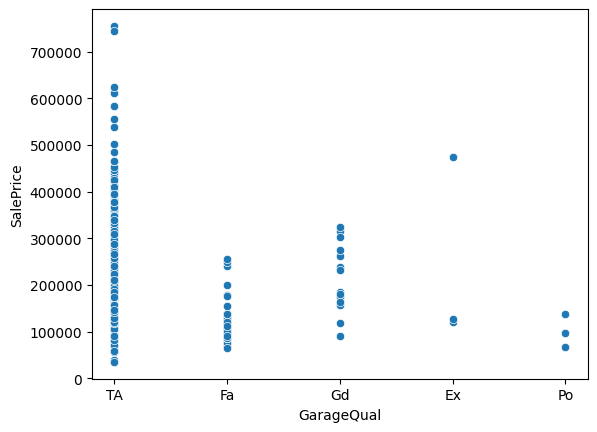

In [3]:
X = load_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col='Id')

#{'OverallQual': 'numeric', 'GarageCars': 'numeric', 'GrLivArea': 'numeric', 'FullBath': 'numeric', 'TotalBsmtSF': 'numeric', 'BsmtQual': 'ordinal', 'KitchenQual': 'ordinal', 'Exterior1st': 'label', 'ExterQual': 'ordinal', 'BsmtFinSF1': 'numeric', 'GarageFinish': 'ordinal', 'OpenPorchSF': 'numeric', 'Exterior2nd': 'label', 'YearBuilt': 'numeric', 'YearRemodAdd': 'numeric', 'BsmtUnfSF': 'numeric', 'FireplaceQu': 'ordinal', 'LotShape': 'onehot', 'BedroomAbvGr': 'numeric', 'GarageType': 'onehot', 'MasVnrType': 'onehot', 'Fireplaces': 'numeric', 'GarageQual': 'ordinal', 'MSSubClass': 'numeric', 'LotArea': 'numeric', 'SaleCondition': 'label', 'BsmtFinType1': 'ordinal', 'SaleType': 'label', 'GarageYrBlt': 'numeric', 'Foundation': 'onehot', 'HeatingQC': 'ordinal', 'OverallCond': 'numeric', 'LotFrontage': 'numeric', 'TotRmsAbvGrd': 'numeric', 'MSZoning': 'label', 'BsmtExposure': 'ordinal', 'Neighborhood': 'label', 'YrSold': 'numeric'}
#sns.scatterplot(data=X, x='GrLivArea', y='TotalBsmtSF',)

#X[(X['TotalBsmtSF']>X['GrLivArea'])][['TotalBsmtSF','GrLivArea']].sort_values(by='TotalBsmtSF')
#X['BasemGreaterLiv'] = (X['TotalBsmtSF']>X['GrLivArea'])
#sns.scatterplot(data=X, x='GrLivArea', y='TotalBsmtSF',hue='BasemGreaterLiv')
#X[X['TotalBsmtSF']>X['GrLivArea']][['TotalBsmtSF','GrLivArea']].sort_values(by='TotalBsmtSF', ascending=False)
#basement>grlivArea
#333, 441, 154
#X['GreatLot'] = (X['LotArea']>100000)
#pd.set_option('display.max_columns', None) 

#sns.scatterplot(data=X, x='LotArea', y='SalePrice')
#X[X['LotArea']>150000]
# 250, 336, 314

sns.scatterplot(data=X, x='GarageQual', y='SalePrice')
#X[X['TotRmsAbvGrd']==14]
# 636

#636, 250, 336, 333, 441

In [4]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import FunctionTransformer


X = load_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col='Id')
#636, 250, 336, 333, 441
delete_noise(X,[524, 1299])
X.reset_index(drop=True)
#correct_nan(X)
y = X.pop('SalePrice')

# Trovo le features che hanno mi>0.09 e li tratto per score decrescente a partire dalla più importante
# Tratto ogni feature secondo la propria tipologia in una pipeline dedicata
# 'Neighborhood': 'label' lo trasferisco nel target encoding
#{'OverallQual': 'numeric', 'GarageCars': 'numeric', 'GrLivArea': 'numeric', 'FullBath': 'numeric', 'TotalBsmtSF': 'numeric', 'BsmtQual': 'ordinal', 'KitchenQual': 'ordinal', 'Exterior1st': 'label', 'ExterQual': 'ordinal', 'BsmtFinSF1': 'numeric', 'GarageFinish': 'ordinal', 'OpenPorchSF': 'numeric', 'Exterior2nd': 'label', 'YearBuilt': 'numeric', 'YearRemodAdd': 'numeric', 'BsmtUnfSF': 'numeric', 'FireplaceQu': 'ordinal', 'LotShape': 'onehot', 'BedroomAbvGr': 'numeric', 'GarageType': 'onehot', 'MasVnrType': 'onehot', 'Fireplaces': 'numeric', 'GarageQual': 'ordinal', 'MSSubClass': 'numeric', 'LotArea': 'numeric', 'SaleCondition': 'label', 'BsmtFinType1': 'ordinal', 'SaleType': 'label', 'GarageYrBlt': 'numeric', 'Foundation': 'onehot', 'HeatingQC': 'ordinal', 'OverallCond': 'numeric', 'LotFrontage': 'numeric', 'TotRmsAbvGrd': 'numeric', 'MSZoning': 'label', 'BsmtExposure': 'ordinal', 'Neighborhood': 'label', 'YrSold': 'numeric'}
#features_mi = {'OverallQual': 'numeric', 'GrLivArea': 'numeric', 'GarageCars': 'numeric', 'KitchenQual': 'ordinal', 'TotalBsmtSF': 'numeric', 'TotRmsAbvGrd': 'numeric', 'ExterQual': 'ordinal', 'BsmtFinSF1': 'numeric', 'FullBath': 'numeric', 'GarageFinish': 'ordinal', 'LotFrontage': 'numeric', 'BsmtExposure': 'ordinal', 'SaleType': 'label', 'YearRemodAdd': 'numeric', 'OverallCond': 'numeric', 'BsmtFinType1': 'ordinal', 'YrSold': 'numeric', 'YearBuilt': 'numeric', 'Foundation': 'onehot', 'SaleCondition': 'label', 'Fireplaces': 'numeric', 'MSSubClass': 'numeric', 'MSZoning': 'label', 'FireplaceQu': 'ordinal', 'Neighborhood': 'label', 'GarageYrBlt': 'numeric', 'BsmtUnfSF': 'numeric', 'OpenPorchSF': 'numeric', 'BedroomAbvGr': 'numeric', 'MasVnrType': 'onehot', 'LotShape': 'onehot', 'BsmtQual': 'ordinal', 'HeatingQC': 'ordinal', 'GarageType': 'onehot', 'LotArea': 'numeric', 'GarageQual': 'ordinal'}
#features_mi =  {'OverallQual': 'numeric', 'GarageCars': 'numeric', 'FullBath': 'numeric', 'GrLivArea': 'numeric', 'TotalBsmtSF': 'numeric', 'BsmtQual': 'ordinal', 'GarageQual': 'ordinal', 'TotRmsAbvGrd': 'numeric', 'BsmtFinSF1': 'numeric', 'KitchenQual': 'ordinal', 'ExterQual': 'ordinal', 'LotArea': 'numeric', 'GarageFinish': 'ordinal', 'BsmtFinType1': 'ordinal', 'SaleCondition': 'label', 'FireplaceQu': 'ordinal', 'YearRemodAdd': 'numeric', 'BsmtExposure': 'ordinal', 'OverallCond': 'numeric', 'Fireplaces': 'numeric', 'YearBuilt': 'numeric', 'SaleType': 'label', 'BedroomAbvGr': 'numeric', 'OpenPorchSF': 'numeric', 'GarageType': 'onehot', 'MasVnrType': 'onehot', 'MSZoning': 'label', 'MSSubClass': 'numeric', 'BsmtUnfSF': 'numeric', 'Neighborhood': 'label', 'YrSold': 'numeric', 'LotShape': 'onehot', 'LotFrontage': 'numeric', 'Foundation': 'onehot', 'GarageYrBlt': 'numeric', 'HeatingQC': 'ordinal'}
#features_mi = {'OverallQual': 'numeric', 'GarageCars': 'numeric', 'FullBath': 'numeric', 'GrLivArea': 'numeric', 'BsmtQual': 'ordinal', 'TotalBsmtSF': 'numeric', 'KitchenQual': 'ordinal', 'TotRmsAbvGrd': 'numeric', 'BsmtFinSF1': 'numeric', 'LotArea': 'numeric', 'GarageQual': 'ordinal', 'ExterQual': 'ordinal', 'HeatingQC': 'ordinal', 'GarageYrBlt': 'numeric', 'Fireplaces': 'numeric', 'GarageFinish': 'ordinal', 'BsmtExposure': 'ordinal', 'YrSold': 'numeric', 'BedroomAbvGr': 'numeric', 'LotFrontage': 'numeric', 'LotShape': 'onehot', 'MasVnrType': 'onehot', 'SaleType': 'label', 'YearRemodAdd': 'numeric', 'MSZoning': 'label', 'GarageType': 'onehot', 'OverallCond': 'numeric', 'YearBuilt': 'numeric', 'FireplaceQu': 'ordinal', 'SaleCondition': 'label', 'Foundation': 'onehot', 'MSSubClass': 'numeric', 'Neighborhood': 'label', 'BsmtUnfSF': 'numeric', 'OpenPorchSF': 'numeric', 'BsmtFinType1': 'ordinal'}
#features_mi = {'OverallQual': 'numeric', 'OpenPorchSF': 'numeric', 'GrLivArea': 'numeric', 'BsmtUnfSF': 'numeric', 'GarageCars': 'numeric', 'TotalBsmtSF': 'numeric', 'OverallCond': 'numeric', 'FullBath': 'numeric', 'ExterQual': 'ordinal', 'TotRmsAbvGrd': 'numeric', 'GarageType': 'onehot', 'MSSubClass': 'numeric', 'Fireplaces': 'numeric', 'FireplaceQu': 'ordinal', 'GarageFinish': 'ordinal', 'BsmtFinType1': 'ordinal', 'HeatingQC': 'ordinal', 'GarageYrBlt': 'numeric', 'SaleCondition': 'label', 'Foundation': 'onehot', 'YearBuilt': 'numeric', 'GarageQual': 'ordinal', 'BedroomAbvGr': 'numeric', 'LotFrontage': 'numeric', 'YrSold': 'numeric', 'BsmtExposure': 'ordinal', 'SaleType': 'label', 'BsmtFinSF1': 'numeric', 'BsmtQual': 'ordinal', 'KitchenQual': 'ordinal', 'LotShape': 'onehot', 'MSZoning': 'label', 'MasVnrType': 'onehot', 'YearRemodAdd': 'numeric', 'LotArea': 'numeric', 'Neighborhood': 'label'}

# Senza Exterior1 and 2nd
# 13535.241991295663 --  {'OverallQual': 'numeric', 'OpenPorchSF': 'numeric', 'GrLivArea': 'numeric', 'BsmtUnfSF': 'numeric', 'GarageCars': 'numeric', 'TotalBsmtSF': 'numeric', 'OverallCond': 'numeric', 'FullBath': 'numeric', 'ExterQual': 'ordinal', 'TotRmsAbvGrd': 'numeric', 'GarageType': 'onehot', 'MSSubClass': 'numeric', 'Fireplaces': 'numeric', 'FireplaceQu': 'ordinal', 'GarageFinish': 'ordinal', 'BsmtFinType1': 'ordinal', 'HeatingQC': 'ordinal', 'GarageYrBlt': 'numeric', 'SaleCondition': 'label', 'Foundation': 'onehot', 'YearBuilt': 'numeric', 'GarageQual': 'ordinal', 'BedroomAbvGr': 'numeric', 'LotFrontage': 'numeric', 'YrSold': 'numeric', 'BsmtExposure': 'ordinal', 'SaleType': 'label', 'BsmtFinSF1': 'numeric', 'BsmtQual': 'ordinal', 'KitchenQual': 'ordinal', 'LotShape': 'onehot', 'MSZoning': 'label', 'MasVnrType': 'onehot', 'YearRemodAdd': 'numeric', 'LotArea': 'numeric', 'Neighborhood': 'label'}
features_mi = {'OverallQual': 'numeric', 'GarageCars': 'numeric', 'FullBath': 'numeric', 'GrLivArea': 'numeric', 'BsmtQual': 'ordinal', 'TotalBsmtSF': 'numeric', 'KitchenQual': 'ordinal', 'TotRmsAbvGrd': 'numeric', 'BsmtFinSF1': 'numeric', 'LotArea': 'numeric', 'GarageQual': 'ordinal', 'ExterQual': 'ordinal', 'HeatingQC': 'ordinal', 'GarageYrBlt': 'numeric', 'Fireplaces': 'numeric', 'GarageFinish': 'ordinal', 'BsmtExposure': 'ordinal', 'YrSold': 'numeric', 'BedroomAbvGr': 'numeric', 'LotFrontage': 'numeric', 'LotShape': 'onehot', 'MasVnrType': 'onehot', 'SaleType': 'label', 'YearRemodAdd': 'numeric', 'MSZoning': 'label', 'GarageType': 'onehot', 'OverallCond': 'numeric', 'YearBuilt': 'numeric', 'FireplaceQu': 'ordinal', 'SaleCondition': 'label', 'Foundation': 'onehot', 'MSSubClass': 'numeric', 'Neighborhood': 'label', 'BsmtUnfSF': 'numeric', 'OpenPorchSF': 'numeric', 'BsmtFinType1': 'ordinal'}
#features_mi =  {'OverallQual': 'numeric', 'FullBath': 'numeric', 'GrLivArea': 'numeric', 'TotalBsmtSF': 'numeric', 'GarageCars': 'numeric', 'KitchenQual': 'ordinal', 'BsmtQual': 'ordinal', 'TotRmsAbvGrd': 'numeric', 'BsmtFinSF1': 'numeric', 'GarageQual': 'ordinal', 'LotArea': 'numeric', 'ExterQual': 'ordinal', 'GarageFinish': 'ordinal', 'SaleType': 'label', 'GarageType': 'onehot', 'FireplaceQu': 'ordinal', 'MSZoning': 'label', 'BsmtFinType1': 'ordinal', 'Fireplaces': 'numeric', 'YearBuilt': 'numeric', 'YearRemodAdd': 'numeric', 'BsmtExposure': 'ordinal', 'LotFrontage': 'numeric', 'MasVnrType': 'onehot', 'SaleCondition': 'label', 'Neighborhood': 'label', 'BsmtUnfSF': 'numeric', 'OverallCond': 'numeric', 'BedroomAbvGr': 'numeric', 'MSSubClass': 'numeric', 'Foundation': 'onehot', 'LotShape': 'onehot', 'YrSold': 'numeric', 'OpenPorchSF': 'numeric', 'GarageYrBlt': 'numeric', 'HeatingQC': 'ordinal'}
#features_mi = {'OverallQual': 'numeric', 'GarageCars': 'numeric', 'GrLivArea': 'numeric', 'FullBath': 'numeric', 'TotalBsmtSF': 'numeric', 'BsmtQual': 'ordinal', 'KitchenQual': 'ordinal', 'Exterior1st': 'label', 'ExterQual': 'ordinal', 'BsmtFinSF1': 'numeric', 'GarageFinish': 'ordinal', 'OpenPorchSF': 'numeric', 'Exterior2nd': 'label', 'YearBuilt': 'numeric', 'YearRemodAdd': 'numeric', 'BsmtUnfSF': 'numeric', 'FireplaceQu': 'ordinal', 'LotShape': 'onehot', 'BedroomAbvGr': 'numeric', 'GarageType': 'onehot', 'MasVnrType': 'onehot', 'Fireplaces': 'numeric', 'GarageQual': 'ordinal', 'MSSubClass': 'numeric', 'LotArea': 'numeric', 'SaleCondition': 'label', 'BsmtFinType1': 'ordinal', 'SaleType': 'label', 'GarageYrBlt': 'numeric', 'Foundation': 'onehot', 'HeatingQC': 'ordinal', 'OverallCond': 'numeric', 'LotFrontage': 'numeric', 'TotRmsAbvGrd': 'numeric', 'MSZoning': 'label', 'BsmtExposure': 'ordinal', 'Neighborhood': 'label', 'YrSold': 'numeric'}
#13541.014251569635 -- features_mi = {'GrLivArea': 'numeric', 'OverallQual': 'numeric', 'YearBuilt': 'numeric', 'YearRemodAdd': 'numeric', 'YrSold': 'numeric','Neighborhood': 'label','OverallCond': 'numeric',  'GarageCars': 'numeric','BsmtQual': 'ordinal', 'BsmtUnfSF': 'numeric',  'TotRmsAbvGrd': 'numeric', 'KitchenQual': 'ordinal', 'BsmtFinSF1': 'numeric', 'FireplaceQu': 'ordinal',  'SaleCondition': 'label', 'Exterior2nd': 'onehot', 'ExterQual': 'ordinal', 'Fireplaces': 'numeric', 'LotArea': 'numeric', 'SaleType': 'label', 'HeatingQC': 'ordinal', 'TotalBsmtSF': 'numeric', 'BedroomAbvGr': 'numeric', 'MSZoning': 'onehot', 'Foundation': 'onehot', 'LotFrontage': 'numeric', 'GarageType': 'onehot', 'Exterior1st': 'onehot', 'LotShape': 'onehot', 'GarageQual': 'ordinal', 'BsmtExposure': 'ordinal', 'BsmtFinType1': 'ordinal', 'GarageYrBlt': 'numeric', 'MSSubClass': 'numeric', 'OpenPorchSF': 'numeric', 'FullBath': 'numeric',  'GarageFinish': 'ordinal', 'MasVnrType': 'onehot'}
'''
features_mi = {'OverallQual':'numeric',
            'Neighborhood':'label',
            'GrLivArea':'numeric',
            'YearBuilt':'numeric',
            'TotalBsmtSF':'numeric',
            'LotArea':'numeric',
            'GarageCars':'numeric',
            'BsmtQual':'ordinal',
            'KitchenQual':'ordinal',
            'ExterQual':'ordinal',
            'MSSubClass':'numeric',
            'YearRemodAdd':'numeric',
            'GarageFinish':'ordinal',
            'FullBath':'numeric',
            'GarageYrBlt':'numeric',
            'FireplaceQu':'ordinal',
            'TotRmsAbvGrd':'numeric',
            'LotFrontage':'numeric',
            'GarageType':'onehot',
            'Foundation':'onehot',
            'OpenPorchSF':'numeric',
            'Fireplaces':'numeric',
            'Exterior2nd':'onehot',
            'HeatingQC':'ordinal',
            'BsmtFinType1':'ordinal',
            'BsmtFinSF1':'numeric',
            'Exterior1st':'onehot',
            'MSZoning':'onehot',
            'OverallCond':'numeric',
            'BsmtUnfSF':'numeric',
            'MasVnrType':'onehot',
            'LotShape':'onehot'}
'''

# Eseguo la build di più modelli ognuno dei quali viene addestrato con un proprio elenco ordinato e alla fine combino 
# le previsioni

def build_Launch(X, features):
    mi_features = [key for key in features.keys()]
    # Devo aggiungere i campi che vengono gestiti come featureengeneering
    featuresOfInterest = mi_features.copy()
    #featuresOfInterest.append('Neighborhood')
    
    X = X[featuresOfInterest].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

    # Pipeline OrdinalEncoding
    orderedCategories = [['na', 'unf', 'rfn', 'fin', 'lwq', 'rec', 'blq', 'alq', 
                          'glq', 'no', 'mn', 'av', 'po', 'fa', 'ta', 'gd', 'ex']]
    ordinal_transformer = Pipeline(steps=[
        ('lowercase', LowercaseTransformer()),
        ('imputer', SimpleImputer(strategy='constant', fill_value='na')),
        ('ordinalencoder', OrdinalEncoder(categories=orderedCategories)),
    ])
    # Pipeline labelEncoding
    label_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
        ('cat_label', FunctionTransformer(label_encode, validate=False))
    ])
    
    transformers=[]
    features_complete = []
    
    for i, (key, value) in enumerate(features.items(), start=1):
        if value == 'label':
            transformers.append((f'label{i}', label_transformer, [key]))
            
        elif value == 'numeric':
            transformers.append((f'numeric{i}', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                                                ('scaler', StandardScaler())]), [key]))
        elif value == 'onehot':
            transformers.append((f'onehot{i}', Pipeline(steps=[('onehot', OneHotWithOther(column_names=[key], perc_thresholdOther=0.015))]), [key]))
            
        elif value == 'ordinal':
            transformers.append((f'ordinal{i}', ordinal_transformer, [key]))
            
        features_complete.append(key) 
    
    # Visualizza i trasformatori creati
    #print(transformers)
    transformers.append(('passthrough', 'passthrough',['price_mean_nbrhd']))

    preprocessor = ColumnTransformer(transformers=transformers)  
    
    # Verifico la struttura dati
    #X_train_encoded = preprocessor.fit_transform(X_train, y_train)
    
#TOP    model = XGBRegressor(learning_rate=0.04, max_depth=7, n_estimators=200, subsample=0.5)
    model = XGBRegressor(learning_rate=0.04, max_depth=7, n_estimators=200, subsample=0.5)
    
    # Pipeline finale
    pipeline = Pipeline(steps=[
        ('target_encoder', TargetEncoder(weight=0.7)),        
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    predictions = pipeline.predict(X_test)
    
    # Calcolo della MAE
    mae = mean_absolute_error(y_test, predictions)
#    print(f'Mean Absolute Error (MAE): {mae}')
    
    
#    xgb.plot_importance(model, max_num_features=40, importance_type='weight')
#    plt.title('Importanza delle Feature')
#    plt.xlabel('Peso')
#    plt.ylabel('Feature')
#    plt.show()
    
    importances = model.feature_importances_
    
    new_iteration = {}
    for i, item in enumerate(features_complete):
        new_iteration[item]= importances[i]
    
    next_iteration = pd.DataFrame(list(new_iteration.items()), columns=['Feature', 'Importance'])
    next_iteration = next_iteration.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    return (next_iteration,mae)

bestMae = 15000
newIteration = features_mi


for i in range(1,15001):
    next_iteration_proposed, mae = build_Launch(X, newIteration)
    if(mae<bestMae):
        print(f'mae:{mae} Improvement by {bestMae-mae}')
        bestMae = mae
        bestIteration = newIteration
        print(f'best iteration so far: {newIteration}')
        
    newIteration = {}
    for index, row in next_iteration_proposed.iterrows():
        newIteration[row[0]] = features_mi.get(row[0])

    if i%100==0:
        print(f'{i} iterazioni effettuate')
    



mae:13580.081264269407 Improvement by 1419.9187357305927
best iteration so far: {'OverallQual': 'numeric', 'GarageCars': 'numeric', 'FullBath': 'numeric', 'GrLivArea': 'numeric', 'BsmtQual': 'ordinal', 'TotalBsmtSF': 'numeric', 'KitchenQual': 'ordinal', 'TotRmsAbvGrd': 'numeric', 'BsmtFinSF1': 'numeric', 'LotArea': 'numeric', 'GarageQual': 'ordinal', 'ExterQual': 'ordinal', 'HeatingQC': 'ordinal', 'GarageYrBlt': 'numeric', 'Fireplaces': 'numeric', 'GarageFinish': 'ordinal', 'BsmtExposure': 'ordinal', 'YrSold': 'numeric', 'BedroomAbvGr': 'numeric', 'LotFrontage': 'numeric', 'LotShape': 'onehot', 'MasVnrType': 'onehot', 'SaleType': 'label', 'YearRemodAdd': 'numeric', 'MSZoning': 'label', 'GarageType': 'onehot', 'OverallCond': 'numeric', 'YearBuilt': 'numeric', 'FireplaceQu': 'ordinal', 'SaleCondition': 'label', 'Foundation': 'onehot', 'MSSubClass': 'numeric', 'Neighborhood': 'label', 'BsmtUnfSF': 'numeric', 'OpenPorchSF': 'numeric', 'BsmtFinType1': 'ordinal'}
100 iterazioni effettuate
20